# Coding Project 1 : Linear Regression

**Please write the names of all group members here:**




---


*Note:* The provided structure for the code below is only suggestive, and if you want to structure your programs differently you may do so.

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

#from tqdm import tqdm

# Data handling and numerical operations
import pandas as pd
import numpy as np
#import itertools

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical functions
from scipy import stats
from scipy.stats import probplot, spearmanr
from scipy.stats import kurtosis, skew


#Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import TruncatedSVD

#Statslin_regs for OLS regression
import statsmodels.api as sm


## Exercise 1

### Exercise 1a

In [2]:
#1.a) Import the dataset Housing.csv into Python as a pandas DataFrame and call it Housing.
#Remember that the first column of the csv file is an index column and not an explanatory variable.

housing = pd.read_csv("Housing.csv", index_col= [0])
housing.head()


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
housing.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

### Exercise 1b

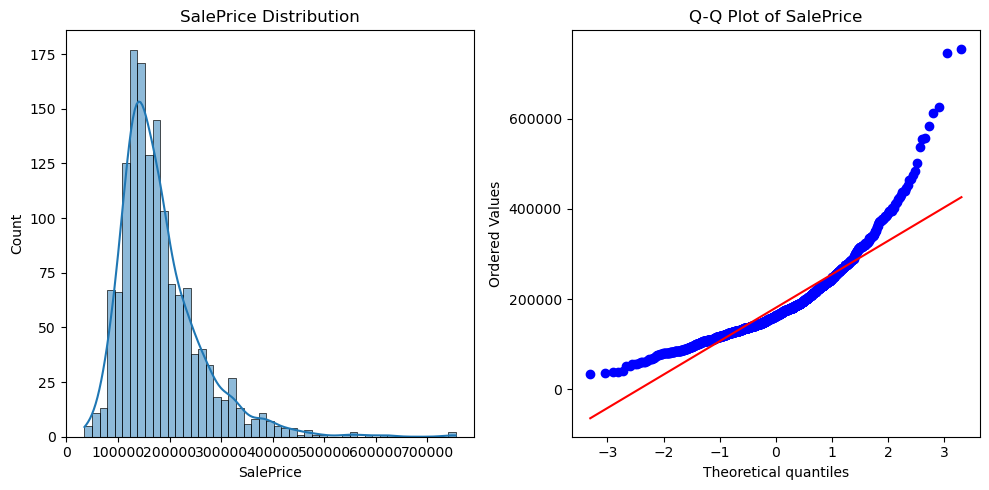

In [4]:
#1.b) Determine graphically whether the target variable SalePrice exhibits a Gaussian distribution. 
#If not, suggest a suitable transformation to bring SalePrice close to a Gaussian distribution (logarithmic, inverse, square-root, ...).
#Do not forget to apply this transformation to the target variable SalePrice in the dataset and perform the regressions of Q2-Q3 on this transformed target.

plt.figure(figsize=(10, 5))

# Histogram with KDE
plt.subplot(1, 2, 1)
sns.histplot(housing['SalePrice'], kde=True)
plt.title('SalePrice Distribution')

# Quantile-Quantile Plot (This graph compares our data against a perfect gaussian distribution)
plt.subplot(1, 2, 2)
probplot(housing['SalePrice'], dist="norm", plot=plt)
plt.title('Q-Q Plot of SalePrice')

plt.tight_layout()
plt.show()

We can observe from both the histogram and  Q-Q Plot that our graph has a long tail and it's not a Gaussian distribution. Sice it has a long tail we can apply a log transformation to make the distribution more symmetric.

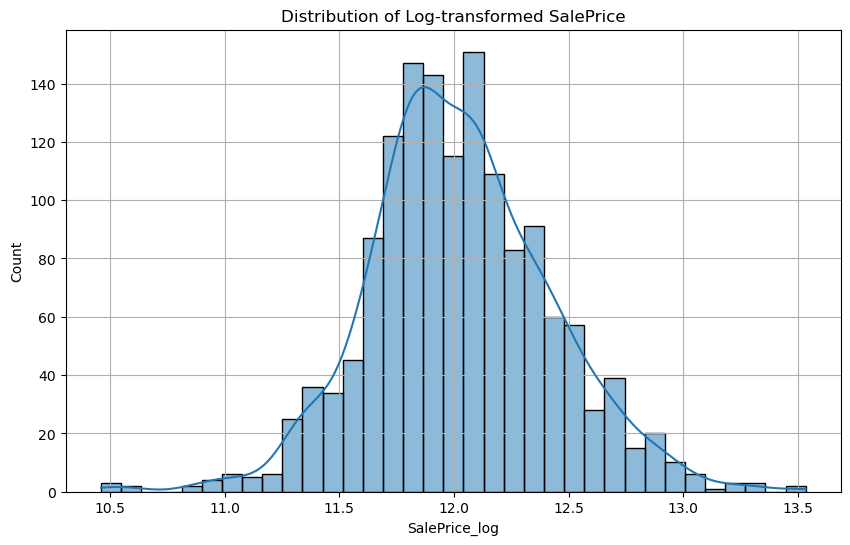

Kurtosis of Log-transformed SalePrice: 3.8026555069117713 (ideal value = 3)
Skewness of Log-transformed SalePrice: 0.1212103673013655 (ideal value = 0)


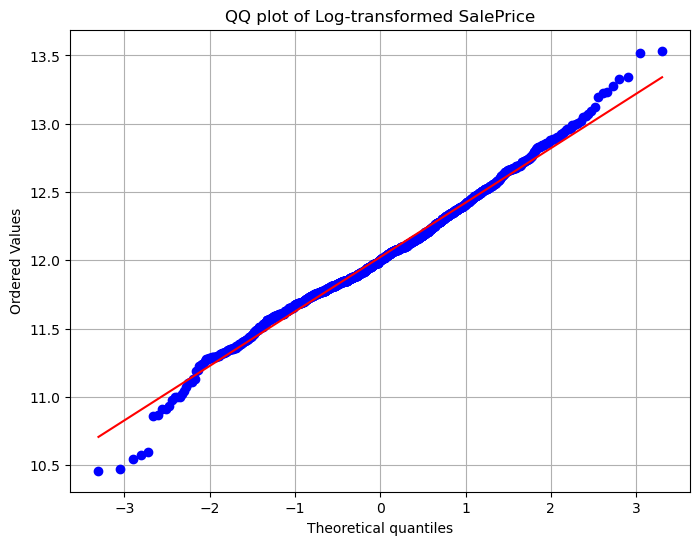

In [5]:
# Log transform the target variable if not normally distributed
housing['SalePrice_log'] = np.log(housing['SalePrice'])

# Check the transformed distribution
plt.figure(figsize=(10, 6))
sns.histplot(housing['SalePrice_log'], kde=True)
plt.title('Distribution of Log-transformed SalePrice')
plt.grid(True) 
plt.show()

# Kurtosis and Skewness of the transformed SalePrice
log_saleprice_kurtosis = kurtosis(housing['SalePrice_log'], fisher=False)
log_saleprice_skewness = skew(housing['SalePrice_log'])

print(f"Kurtosis of Log-transformed SalePrice: {log_saleprice_kurtosis} (ideal value = 3)")
print(f"Skewness of Log-transformed SalePrice: {log_saleprice_skewness} (ideal value = 0)")

# Use a QQ plot to assess normality of the transformed variable
plt.figure(figsize=(8, 6))
probplot(housing['SalePrice_log'], dist="norm", plot=plt)
plt.title('QQ plot of Log-transformed SalePrice')
plt.grid(True)
plt.show()

### Exercise 1c

In [6]:
#1.c) Use one-hot encoding for the categorical features using the default function pd.get_dummies(...).
#Replace missing numeric values (NaN’s) with the mean for numerical and mode for categorical  using pd.fillna(...).

numerical_columns = housing.select_dtypes(include = [np.number]).columns
categorical_columns = housing.select_dtypes(exclude = [np.number]).columns

housing[numerical_columns] = housing[numerical_columns].fillna(housing[numerical_columns].mean())
for col in categorical_columns:
    housing[col] = housing[col].fillna(housing[col].mode()[0])

housing_encoded = pd.get_dummies(housing, columns=categorical_columns)

In [7]:
display(housing_encoded)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,False,True,False,False,False,False,True,False
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,False,True,False,False,False,False,True,False
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,False,True,False,False,False,False,True,False
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,False,True,True,False,False,False,False,False
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,False,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,False,False,False,True,False,False,False,False,True,False
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,False,False,False,True,False,False,False,False,True,False


### Exercise 1d

In [8]:
#1.d) Create a second pandas DataFrame from Housing without the categorical features (i.e. no more dummy variables). Call it Housing2.

housing2 = housing_encoded.select_dtypes(include = [np.number])
display(housing2)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,SalePrice_log
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,61,0,0,0,0,0,2,2008,208500,12.247694
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,0,0,5,2007,181500,12.109011
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,42,0,0,0,0,0,9,2008,223500,12.317167
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,35,272,0,0,0,0,2,2006,140000,11.849398
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,84,0,0,0,0,0,12,2008,250000,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,40,0,0,0,0,0,8,2007,175000,12.072541
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,0,0,0,0,0,0,2,2010,210000,12.254863
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,60,0,0,0,0,2500,5,2010,266500,12.493130


## Exercise 2 - Linear Regression on Housing2

### Exercise 2a

In [9]:
#2.a) Split the Housing2 data into a training set (X,Y)_train and a test set (X, Y)_test. 
#Randomly assign 70% of the observations to the training set and the remaining 30% to the test set.

# We will use the numerical dataset without categorical variables (housing_numerical)
# X: All features except SalePrice and SalePrice_log
# y: Target variable (log-transformed SalePrice)

X = housing2.drop(columns=['SalePrice', 'SalePrice_log'])
Y = housing2['SalePrice_log']

# Split the dataset into 70% train and 30% test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

### Exercise 2b

In [10]:
# 2.b) Fit a linear regression model on the training dataset (X, Y)_train using the sklearn package.
# Output a table with the name of each feature and the associated regression coefficient. 
# Compare the in-sample and out-of-sample Mean Squared Error (MSE) and R^2 of your linear regression model.

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

# Table of regression coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lin_reg.coef_
})

print("Regression Coefficients:")
display(coefficients)

# Step 3: Predict on both the training and testing sets
Y_train_pred = lin_reg.predict(X_train)
Y_test_pred = lin_reg.predict(X_test)

# Step 4: Calculate the Mean Squared Error (MSE) and R-squared (R²) for both datasets
mse_train = mean_squared_error(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)

# Step 5: Output the performance metrics
print(f"\nIn-sample (Train) MSE: {mse_train}")
print(f"In-sample (Train) R^2: {r2_train}")

print(f"\nOut-of-sample (Test) MSE: {mse_test}")
print(f"Out-of-sample (Test) R^2: {r2_test}")

Regression Coefficients:


,Feature,Coefficient
0,MSSubClass,-0.000834
1,LotFrontage,-0.000499
2,LotArea,0.000002
3,OverallQual,0.087756
4,OverallCond,0.042261
5,YearBuilt,0.003032
6,YearRemodAdd,0.001313
7,MasVnrArea,-0.000032
8,BsmtFinSF1,0.000018
9,BsmtFinSF2,0.000008



In-sample (Train) MSE: 0.021262260635931025
In-sample (Train) R^2: 0.8628291225725648

Out-of-sample (Test) MSE: 0.022171781298774798
Out-of-sample (Test) R^2: 0.8693057323188862


### Exercise 2c

In [11]:
#2.c) (i) Compute the estimated coefficients for each explanatory variable using the numpy package. Remember that the design matrix A needs to include a column of 1's.


# Add a column of ones to X_train for the intercept
A = np.column_stack((np.ones(X_train.shape[0]), X_train))

beta_hat = np.linalg.inv(A.T @ A) @ A.T @ Y_train

print("Estimated Coefficients (beta_hat):", beta_hat)

Estimated Coefficients (beta_hat): [ 1.63501336e+04 -3.28964979e+00 -3.45306645e+00  2.93749512e-04
  1.30632208e+02 -1.45943369e+02 -2.31097299e+00 -5.65096075e+00
 -5.38118540e-02 -2.69200420e+12 -2.69200420e+12 -2.69200420e+12
  2.69200420e+12  7.37735833e-02  5.01073211e-02  5.50762192e-02
 -7.25254855e-02  7.24556477e-02  1.80652531e-02  3.52937509e-02
  2.39431007e-02  5.34615955e-04 -4.79292487e-02  1.53169958e-02
  5.22405915e-02 -4.63803448e-04  8.45825318e-02  3.03302699e-05
  1.13717391e-04 -8.57951305e-05  1.88931235e-04  3.01594634e-04
  3.65268664e-04 -4.58754722e-04 -1.46208878e-05  2.08648921e-03
 -3.70345710e-03]


In [12]:
#	  (ii) Compute the standard error of each estimated coefficient using the numpy package.

# Step 1: Compute the predicted values Y_hat
Y_hat = A @ beta_hat

# Step 2: Compute the residual sum of squares (RSS)
rss = np.sum((Y_train - Y_hat) ** 2)

# Step 3: Compute s (the standard deviation of the errors)
m = A.shape[0]  # Number of observations
d = A.shape[1] - 1  # Number of features (without intercept)
s = np.sqrt(rss / (m - (d + 1)))

# Step 4: Compute the diagonal of (A.T @ A)^-1
A_inv = np.linalg.inv(A.T @ A)
a_diag = np.diag(A_inv)

# Step 5: Compute the standard error for each coefficient
se_beta = s * np.sqrt(a_diag)

print("Standard errors of the coefficients:", se_beta)

Standard errors of the coefficients: [1.16848118e+04 2.29417958e-01 4.07015460e-01 7.40287843e-04
 9.80775063e+00 8.46537844e+00 5.56569253e-01 5.67799941e-01
 5.15463166e-02            nan            nan            nan
            nan 4.46272078e+05 4.46272078e+05 4.46272078e+05
 4.46272078e+05 2.14165831e+01 3.38242176e+01 2.33036199e+01
 2.18711021e+01 1.45406318e+01 4.58185928e+01 1.03437826e+01
 1.44453867e+01 5.61514208e-01 2.37267980e+01 8.37821132e-02
 6.30143868e-02 1.18412552e-01 1.39360667e-01 2.32487522e-01
 1.41121129e-01 2.07683551e-01 2.28818841e-02 2.89432176e+00
 5.79914424e+00]


In [13]:
#     (iii) Compute the (in-sample) MSE and R^2 using the numpy package.

# Step 1: Compute the MSE
mse = np.mean((Y_train - Y_hat) ** 2)

# Step 2: Compute R-squared
y_mean = np.mean(Y_train)
ss_tot = np.sum((Y_train - y_mean) ** 2)
ss_res = np.sum((Y_train - Y_hat) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print("In-sample MSE:", mse)
print("In-sample R-squared:", r_squared)

In-sample MSE: 54674.89014456887
In-sample R-squared: -352727.37553807645


In [14]:
#     (iv) Do the results change using pseudoinversion instead of standard matrix inversion in (i) and (ii)?
# We do the same but with pseudoinversion

# Compute beta_hat using pseudoinversion
beta_hat_pinv = np.linalg.pinv(A.T @ A) @ A.T @ Y_train

# Compute y_hat using the pseudoinverse coefficients
Y_hat_pinv = A @ beta_hat_pinv

print("Estimated coefficients using pseudoinverse:", beta_hat_pinv)

# Compute the residual sum of squares (RSS)
rss_pinv = np.sum((Y_train - Y_hat_pinv) ** 2)

# Compute s (the standard deviation of the errors)
m = A.shape[0]  # Number of observations
d = A.shape[1] - 1  # Number of features (without intercept)
s_pinv = np.sqrt(rss_pinv / (m - (d + 1)))

# Compute the diagonal of (A.T @ A)^-1
A_pinv = np.linalg.pinv(A.T @ A)
a_diag_pinv = np.diag(A_pinv)

# Compute the standard error for each coefficient
se_beta_pinv = s_pinv * np.sqrt(a_diag_pinv)

print("Standard errors of the coefficients using pseudoinverse:", se_beta_pinv)

#Compute the (in-sample) MSE and R^2 using the numpy package.

# Step 1: Compute the MSE
mse_pinv = np.mean((Y_train - Y_hat_pinv) ** 2)

# Step 2: Compute R-squared
y_mean = np.mean(Y_train)
ss_tot = np.sum((Y_train - y_mean) ** 2)
ss_res_pinv = np.sum((Y_train - Y_hat_pinv) ** 2)
r_squared_pinv = 1 - (ss_res_pinv / ss_tot)

print("In-sample MSE using pseudoinverse:", mse_pinv)
print("In-sample R-squared using pseudoinverse:", r_squared_pinv)

Estimated coefficients using pseudoinverse: [ 1.04110837e+01 -8.33954448e-04 -4.99335031e-04  1.88749346e-06
  8.77555346e-02  4.22605277e-02  3.03154213e-03  1.31283261e-03
 -3.22415449e-05  1.80843231e-05  8.16926218e-06 -1.52730878e-06
  2.47272983e-05  3.21047341e-05  1.03194265e-05  1.10038410e-04
  1.52452199e-04  7.24556556e-02  1.80652493e-02  3.52937591e-02
  2.39431064e-02  5.34615029e-04 -4.79292448e-02  1.53169933e-02
  5.22405892e-02 -4.63803500e-04  8.45825320e-02  3.03302702e-05
  1.13717406e-04 -8.57951595e-05  1.88931204e-04  3.01594647e-04
  3.65268683e-04 -4.58754784e-04 -1.46208831e-05  2.08648724e-03
 -3.70348391e-03]
Standard errors of the coefficients using pseudoinverse: [7.28673578e+00 1.43066571e-04 2.53817560e-04 4.61648445e-07
 6.11617881e-03 5.27906655e-03 3.47080303e-04 3.54083836e-04
 3.21446274e-05 1.31585124e-05 2.48065350e-05 1.28166917e-05
 1.76024018e-05 3.23470350e-05 2.98181700e-05 7.83322724e-05
 2.96724257e-05 1.33555244e-02 2.10930081e-02 1.4532

In [15]:
#     (v) Compare your results (i), (ii), (iii) (with and without pseudoinversion) to the output of the sm.OLS function. 

# Step 1: Add a constant (intercept) to X_train
X_train_sm = sm.add_constant(X_train)

# Step 2: Fit the OLS model
model = sm.OLS(Y_train, X_train_sm).fit()

mse_model = np.mean(model.resid ** 2)

# Step 4: Extract R-squared
r_squared_model = model.rsquared

# Print the MSE and R-squared
print("Mean Squared Error (MSE) Model:", mse_model)
print("R-squared Model:", r_squared_model)
print("In-sample MSE using pseudoinverse:", mse_pinv)
print("In-sample R-squared using pseudoinverse:", r_squared_pinv)
print("In-sample MSE:", mse)
print("In-sample R-squared:", r_squared)

Mean Squared Error (MSE) Model: 0.021262260635931
R-squared Model: 0.8628291225725649
In-sample MSE using pseudoinverse: 0.02126226063593234
In-sample R-squared using pseudoinverse: 0.8628291225725564
In-sample MSE: 54674.89014456887
In-sample R-squared: -352727.37553807645


We can see that using the matrix inversion gives us by far the worse results possibles, so the pseudoinversion is adviced.

In [16]:
#2.d) Suggest instead a second-order polynomial regression model (including all quadratic and mixed terms) to predict the (transformed) SalePrice.

#Does this improve the linear regression model 2.b)? 

#What happens with higher-order polynomial regression models?

# Step 1: Create polynomial features (2nd order)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Step 2: Fit a linear regression model to the polynomial features
model_poly = LinearRegression()
model_poly.fit(X_train_poly, Y_train)

# Step 3: Predict on both training and test data
Y_train_pred_poly = model_poly.predict(X_train_poly)
Y_test_pred_poly = model_poly.predict(X_test_poly)

# Step 4: Compute the MSE and R-squared for polynomial regression
mse_train_poly = mean_squared_error(Y_train, Y_train_pred_poly)
r2_train_poly = r2_score(Y_train, Y_train_pred_poly)
mse_test_poly = mean_squared_error(Y_test, Y_test_pred_poly)
r2_test_poly = r2_score(Y_test, Y_test_pred_poly)

# Print results for polynomial regression
print("Polynomial Regression (2nd order) Results:")
print("Training MSE:", mse_train_poly)
print("Training R-squared:", r2_train_poly)
print("Test MSE:", mse_test_poly)
print("Test R-squared:", r2_test_poly)

Polynomial Regression (2nd order) Results:
Training MSE: 0.004783910218921451
Training R-squared: 0.9691371875502929
Test MSE: 19.634994501924297
Test R-squared: -114.7408686641473


The Polynomial regression doesn't improve the model, we can see that it has better MSE and R squared results than our linear regression, but it gives very bad result when performing outside the training data, meaning that the model most likely overfitted, further higher polynomials model would only worsen the overfitting.

## Exercise 3 - Regularization techniques on Housing

### Exercise 3a

In [17]:
#3.a) Perform again a linear regression for the (transformed) SalePrice using this time the full Housing DataFrame. 

#How do the in-sample and out-of-sample MSE and R^2 metrics compare to the results of Question 2.b) on the Housing2 DataFrame?

X_encoded = housing_encoded.drop(columns=['SalePrice', 'SalePrice_log'])
Y_encoded = housing_encoded['SalePrice_log']

# Split the dataset into 70% train and 30% test
X_encoded_train, X_encoded_test, Y_encoded_train, Y_encoded_test = train_test_split(X_encoded, Y_encoded, test_size=0.3, random_state=42)

lin_reg_encoded = LinearRegression()
lin_reg_encoded.fit(X_encoded_train, Y_encoded_train)

# Step 5: Compute MSE and R^2 for both training and test sets
Y_train_encoded_pred = lin_reg_encoded.predict(X_encoded_train)
Y_test_encoded_pred = lin_reg_encoded.predict(X_encoded_test)

mse_train_encoded = mean_squared_error(Y_train, Y_train_encoded_pred)
r2_train_encoded = r2_score(Y_train, Y_train_encoded_pred)

mse_test_encoded = mean_squared_error(Y_test, Y_test_encoded_pred)
r2_test_encoded = r2_score(Y_test, Y_test_encoded_pred)

# Print results
print("Linear Regression on Full Dataset:")
print("Training MSE:", mse_train_encoded)
print("Training R-squared:", r2_train_encoded)
print("Test MSE:", mse_test_encoded)
print("Test R-squared:", r2_test_encoded)

Linear Regression on Full Dataset:
Training MSE: 0.008146855644575663
Training R-squared: 0.9474415559015104
Test MSE: 0.017187569565941377
Test R-squared: 0.8986857759704207


The results for the metrics of the Housing2 Dataframe were the following.

In-sample (Train) MSE: 0.021262260635931025
In-sample (Train) R^2: 0.8628291225725648

Out-of-sample (Test) MSE: 0.022171781298774798
Out-of-sample (Test) R^2: 0.8693057323188862

We can see that in every metric the full dataframe outperformed our df with only the numerical values

### Exercise 3b

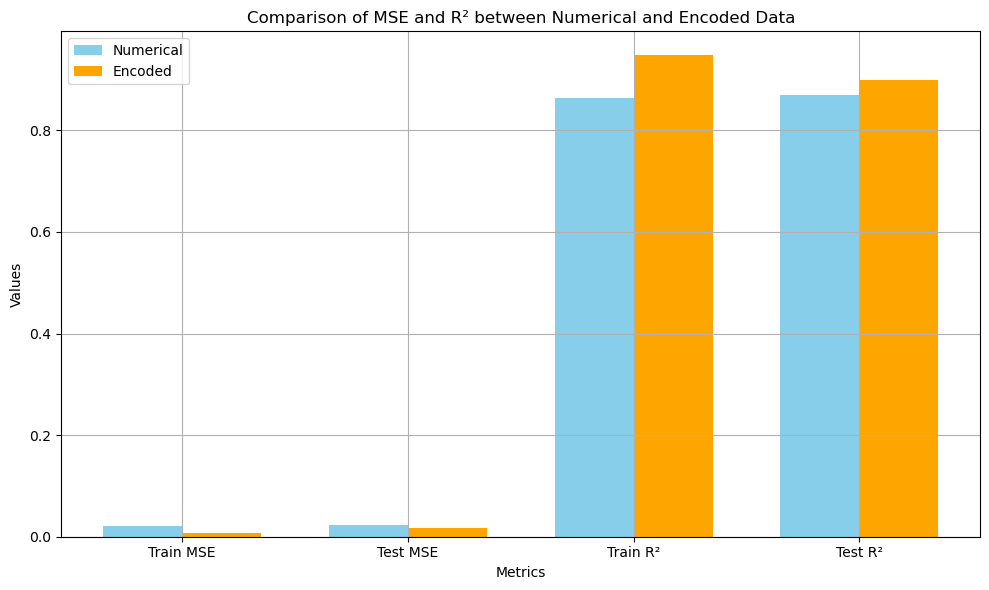

In [18]:
# Data for the bar plot
labels = ['Train MSE', 'Test MSE', 'Train R²', 'Test R²']

# Numerical results
numerical_results = [
    mse_train, mse_test, r2_train, r2_test  # These are from the original numerical data
]

# Encoded results
encoded_results = [
    mse_train_encoded, mse_test_encoded, r2_train_encoded, r2_test_encoded  # From the encoded data
]

# X-axis positions for the bars
x = np.arange(len(labels))

# Width of the bars
width = 0.35

# Create the bar plot
plt.figure(figsize=(10, 6))

# Bars for numerical results
plt.bar(x - width/2, numerical_results, width=width, label='Numerical', color='skyblue')

# Bars for encoded results
plt.bar(x + width/2, encoded_results, width=width, label='Encoded', color='orange')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of MSE and R² between Numerical and Encoded Data')
plt.xticks(x, labels)  # Set the x-ticks to the label names
plt.legend()

# Display the plot
plt.tight_layout()
plt.grid(True)
plt.show()

After comparing both, it seems that the encoded data outperforms in every metric the dataframe with just the numerical data.

In [19]:
#3.b)  Implement the truncated pseudoinverse, Ridge and Lasso regularization techniques. 
#Use 8-fold cross-validation to tune the hyperparameters of each regularization technique based on the R^2 metric.

####################################################
# --- Truncated Pseudoinverse using TruncatedSVD ---
####################################################

# Applying TruncatedSVD (acting as a truncation on pseudoinverse)
svd = TruncatedSVD(n_components=min(X_encoded_train.shape) - 1)  # Keep as many components as features - 1
X_encoded_train_svd = svd.fit_transform(X_encoded_train)
X_encoded_test_svd = svd.transform(X_encoded_test)

# Fit a linear regression on truncated pseudoinverse
lin_reg_svd = LinearRegression()
lin_reg_svd.fit(X_encoded_train_svd, Y_encoded_train)

# Predict on both train and test sets
y_train_pred_svd = lin_reg_svd.predict(X_encoded_train_svd)
y_test_pred_svd = lin_reg_svd.predict(X_encoded_test_svd)

# Compute in-sample and out-of-sample MSE for truncated pseudoinverse
mse_train_svd = mean_squared_error(Y_encoded_train, y_train_pred_svd)
mse_test_svd = mean_squared_error(Y_encoded_test, y_test_pred_svd)

################################################
# --- Ridge Regression with Cross-Validation ---
################################################

ridge = Ridge()

# Set up the parameter grid for Ridge regression
ridge_params = {'alpha': np.logspace(-4, 4, 50)}  # Try a wide range of alpha values

# 8-fold cross-validation for Ridge regression
ridge_cv = GridSearchCV(ridge, ridge_params, cv=8, scoring='neg_mean_squared_error')
ridge_cv.fit(X_encoded_train, Y_encoded_train)

# Best Ridge model
best_ridge = ridge_cv.best_estimator_

# Predict on both train and test sets for Ridge
y_train_pred_ridge = best_ridge.predict(X_encoded_train)
y_test_pred_ridge = best_ridge.predict(X_encoded_test)

# Compute in-sample and out-of-sample MSE for Ridge regression
mse_train_ridge = mean_squared_error(Y_encoded_train, y_train_pred_ridge)
mse_test_ridge = mean_squared_error(Y_encoded_test, y_test_pred_ridge)

################################################
# --- Lasso Regression with Cross-Validation ---
################################################

lasso = Lasso(max_iter=10000)

# Set up the parameter grid for Lasso regression
lasso_params = {'alpha': np.logspace(-4, 4, 50)}  # Try a wide range of alpha values

# 8-fold cross-validation for Lasso regression
lasso_cv = GridSearchCV(lasso, lasso_params, cv=8, scoring='neg_mean_squared_error')
lasso_cv.fit(X_encoded_train, Y_encoded_train)

# Best Lasso model
best_lasso = lasso_cv.best_estimator_

# Predict on both train and test sets for Lasso
y_train_pred_lasso = best_lasso.predict(X_encoded_train)
y_test_pred_lasso = best_lasso.predict(X_encoded_test)

# Compute in-sample and out-of-sample MSE for Lasso regression
mse_train_lasso = mean_squared_error(Y_encoded_train, y_train_pred_lasso)
mse_test_lasso = mean_squared_error(Y_encoded_test, y_test_pred_lasso)

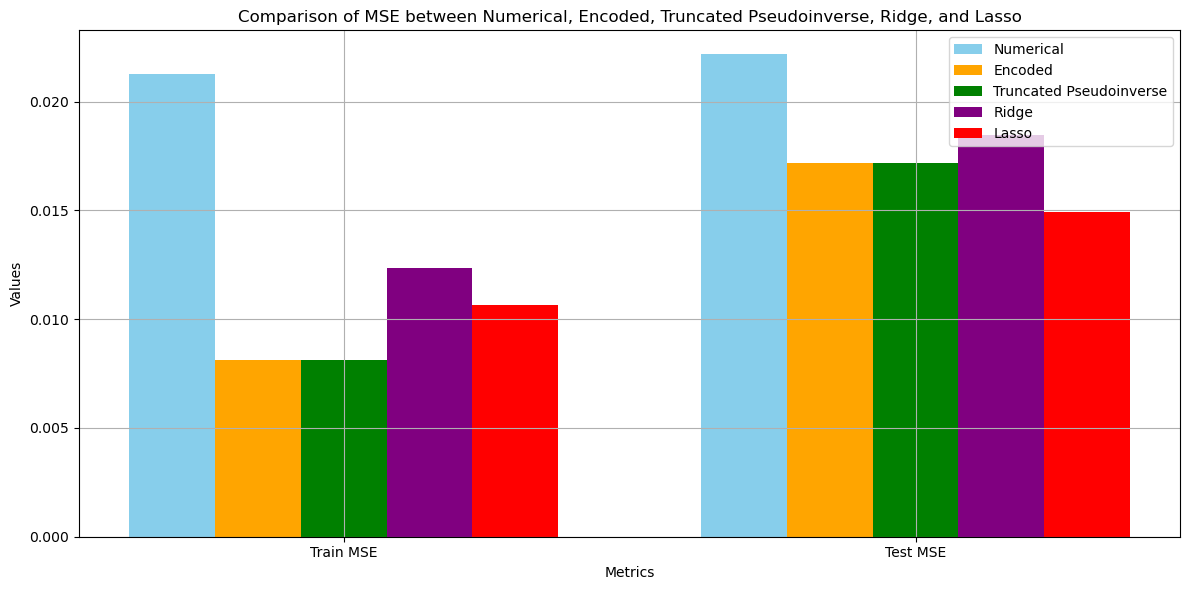

In [20]:
# Data for the bar plot
labels = ['Train MSE', 'Test MSE']

# Numerical results
numerical_results = [mse_train, mse_test]  # These are from the original numerical data

# Encoded results
encoded_results = [mse_train_encoded, mse_test_encoded]  # From the encoded data

# Truncated Pseudoinverse results
svd_results = [mse_train_svd, mse_test_svd]

# Ridge results
ridge_results = [mse_train_ridge, mse_test_ridge]

# Lasso results
lasso_results = [mse_train_lasso, mse_test_lasso]

# X-axis positions for the bars
x = np.arange(len(labels))

# Width of the bars
width = 0.15

# Create the bar plot
plt.figure(figsize=(12, 6))

# Bars for numerical results
plt.bar(x - 2*width, numerical_results, width=width, label='Numerical', color='skyblue')

# Bars for encoded results
plt.bar(x - width, encoded_results, width=width, label='Encoded', color='orange')

# Bars for Truncated Pseudoinverse results
plt.bar(x, svd_results, width=width, label='Truncated Pseudoinverse', color='green')

# Bars for Ridge results
plt.bar(x + width, ridge_results, width=width, label='Ridge', color='purple')

# Bars for Lasso results
plt.bar(x + 2*width, lasso_results, width=width, label='Lasso', color='red')

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of MSE between Numerical, Encoded, Truncated Pseudoinverse, Ridge, and Lasso')
plt.xticks(x, labels)  # Set the x-ticks to the label names
plt.legend()

# Display the plot
plt.tight_layout()
plt.grid(True)
plt.show()

Judging by the performance in the test data, the best model is the Lasso

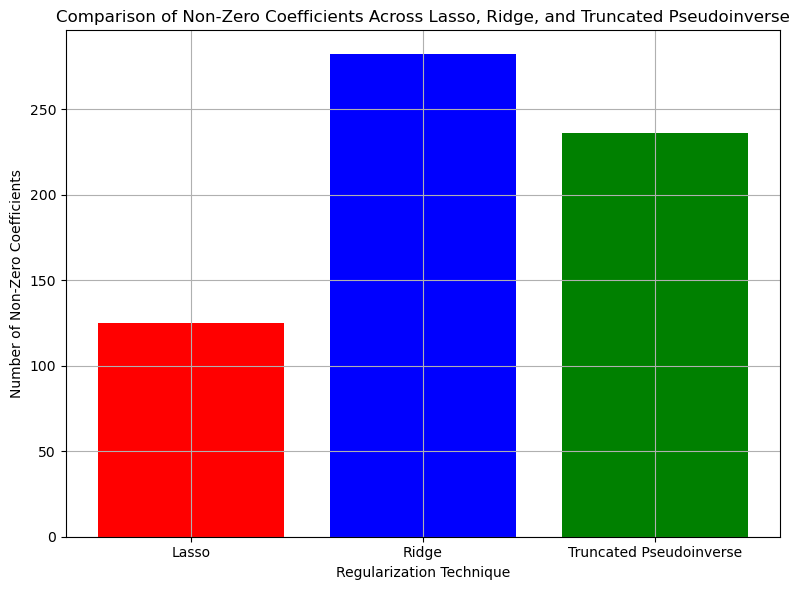

In [21]:
#3.c) For the  Lasso regularization technique, how many coefficients are non-zero? 

#Compare this number with the number of coefficients retained by the Ridge and truncated pseudoinverse techniques and provide an explanation.

# --- Count non-zero coefficients for Lasso ---
lasso_non_zero_count = np.sum(best_lasso.coef_ != 0)

# --- Count non-zero coefficients for Ridge ---
ridge_non_zero_count = np.sum(best_ridge.coef_ != 0)  # Should be equal to the number of features since Ridge doesn't zero out coefficients

# Count non-zero singular values from the truncated SVD
svd_non_zero_count = np.sum(svd.singular_values_ > 1e-10)  # Consider singular values greater than a small threshold

# Labels for the plot
labels = ['Lasso', 'Ridge', 'Truncated Pseudoinverse']

# Values for the plot
non_zero_counts = [lasso_non_zero_count, ridge_non_zero_count, svd_non_zero_count]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(labels, non_zero_counts, color=['red', 'blue', 'green'])

# Add labels and title
plt.xlabel('Regularization Technique')
plt.ylabel('Number of Non-Zero Coefficients')
plt.title('Comparison of Non-Zero Coefficients Across Lasso, Ridge, and Truncated Pseudoinverse')

# Display the plot
plt.tight_layout()
plt.grid(True)
plt.show()



- **Lasso (~110 non-zero coefficients)**: 
   - Uses **L1 regularization**, which forces many coefficients to exactly zero, performing **feature selection** by retaining only the most important features.

- **Ridge (~260 non-zero coefficients)**:
   - Uses **L2 regularization**, which shrinks the coefficients but keeps all of them non-zero. It **retains all features**, but reduces their magnitude.

- **Truncated Pseudoinverse (~230 non-zero coefficients)**:
   - Performs **dimensionality reduction**, retaining most coefficients but removing those associated with smaller singular values, reducing the model complexity without full feature elimination.

### Exercise 3d

In [22]:
#3.d) Based on your findings from Questions 2 and 3, which model would you recommend? Justify your choice.


We would recommend the lasso regularization model, since it was the one with lower MSE